<a href="https://colab.research.google.com/github/jiin124/Dacon/blob/main/%EC%84%9C%EC%9A%B8%EC%8B%9C_%EB%94%B0%EB%A6%89%EC%9D%B4_%EC%9E%90%EC%A0%84%EA%B1%B0_%EC%9D%B4%EC%9A%A9_%EC%98%88%EC%B8%A1_AI%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 서울시 따릉이 자전거 이용 예측 AI 모델

## 컬럼

- id : 고유 id
- hour : 시간
- tempertarue : 기온
- precipitation : 비가 오지 않았으면 0, 비가 오면 1
- windspeed : 풍속(평균)
- humidity : 습도
- visiility : 시정, 시계 특성 기상 상태에 따른 가시성을 의미
- ozone : 오존
- pm10 : 미세먼지(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
- pm2.5 : 미세먼지(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
- count : 시간에 따른 따릉이 대여수

기상 데이터는 하루에 총 8번 3시간 간격으로 발표되는 기상단기예보(SHRT) 데이터를 1일 평균으로 변환한 데이터입니다.

2019년 6월 4일 까지 sky_condition (하늘 상태) 코드 : 맑음(1), 구름조금(2), 구름많음(3), 흐림(4)

2020년 sky_condition (하늘 상태) 코드 : 맑음(1), 구름많음(3), 흐림(4)

precipitation_form (강수 형태) 코드 : 없음(0), 비(1), 진눈깨비(2), 눈(3), 소나기(4)

원본 데이터에는 없음(0), 비(1),소나기(4)가 포함되어있었으며 진눈깨비(2)와 눈(3) 성분은 존재하지 않습니다.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
train=pd.read_csv("train.csv")
test=pd.read_csv('test.csv')


In [ ]:
submission=pd.read_csv('submission.csv')

In [ ]:
train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [ ]:
test.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,0,7,20.7,0.0,1.3,62.0,954.0,0.041,44.0,27.0
1,1,17,30.0,0.0,5.4,33.0,1590.0,0.061,49.0,36.0
2,2,13,19.0,1.0,2.1,95.0,193.0,0.020,36.0,28.0
3,4,6,22.5,0.0,2.5,60.0,1185.0,0.027,52.0,38.0
4,5,22,14.6,1.0,3.4,93.0,218.0,0.041,18.0,15.0


In [ ]:
train.columns

Index(['id', 'hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
       'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5', 'count'],
      dtype='object')

In [ ]:
test.columns

Index(['id', 'hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
       'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5'],
      dtype='object')

In [ ]:
train.columns=['id','hour','temperature','precipitation','windspeed','humidity','visibility',
               'ozone','pm10','pm2.5','count']
train.columns

Index(['id', 'hour', 'temperature', 'precipitation', 'windspeed', 'humidity',
       'visibility', 'ozone', 'pm10', 'pm2.5', 'count'],
      dtype='object')

In [ ]:
test.columns=['id','hour','temperature','precipitation','windspeed','humidity','visibility',
               'ozone','pm10','pm2.5']
test.head()

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5
0,0,7,20.7,0.0,1.3,62.0,954.0,0.041,44.0,27.0
1,1,17,30.0,0.0,5.4,33.0,1590.0,0.061,49.0,36.0
2,2,13,19.0,1.0,2.1,95.0,193.0,0.020,36.0,28.0
3,4,6,22.5,0.0,2.5,60.0,1185.0,0.027,52.0,38.0
4,5,22,14.6,1.0,3.4,93.0,218.0,0.041,18.0,15.0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1459 non-null   int64  
 1   hour           1459 non-null   int64  
 2   temperature    1457 non-null   float64
 3   precipitation  1457 non-null   float64
 4   windspeed      1450 non-null   float64
 5   humidity       1457 non-null   float64
 6   visibility     1457 non-null   float64
 7   ozone          1383 non-null   float64
 8   pm10           1369 non-null   float64
 9   pm2.5          1342 non-null   float64
 10  count          1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


In [ ]:
train.describe()

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count
count,1459.000000,1459.000000,1457.000000,1457.000000,1450.000000,1457.000000,1457.000000,1383.000000,1369.000000,1342.000000,1459.000000
mean,1105.914325,11.493489,16.717433,0.031572,2.479034,52.231297,1405.216884,0.039149,57.168736,30.327124,108.563400
std,631.338681,6.922790,5.239150,0.174917,1.378265,20.370387,583.131708,0.019509,31.771019,14.713252,82.631733
min,3.000000,0.000000,3.100000,0.000000,0.000000,7.000000,78.000000,0.003000,9.000000,8.000000,1.000000
25%,555.500000,5.500000,12.800000,0.000000,1.400000,36.000000,879.000000,0.025500,36.000000,20.000000,37.000000
50%,1115.000000,11.000000,16.600000,0.000000,2.300000,51.000000,1577.000000,0.039000,51.000000,26.000000,96.000000
75%,1651.000000,17.500000,20.100000,0.000000,3.400000,69.000000,1994.000000,0.052000,69.000000,37.000000,150.000000
max,2179.000000,23.000000,30.000000,1.000000,8.000000,99.000000,2000.000000,0.125000,269.000000,90.000000,431.000000


In [ ]:
train.isnull().sum()

id                 0
hour               0
temperature        2
precipitation      2
windspeed          9
humidity           2
visibility         2
ozone             76
pm10              90
pm2.5            117
count              0
dtype: int64

In [ ]:
test.isnull().sum()

id                0
hour              0
temperature       1
precipitation     1
windspeed         1
humidity          1
visibility        1
ozone            35
pm10             37
pm2.5            36
dtype: int64

## EDA

In [ ]:
train[['hour','count']].groupby('hour').mean()

,count
hour,
0,71.766667
1,47.606557
2,31.409836
3,21.377049
4,13.524590
5,13.114754
6,24.557377
7,62.360656
8,136.688525


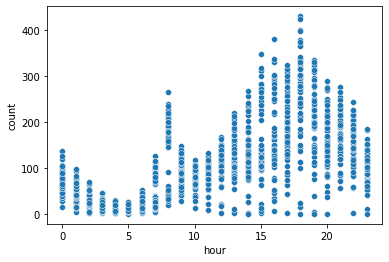

In [ ]:
sns.scatterplot(x='hour',y='count',data=train)

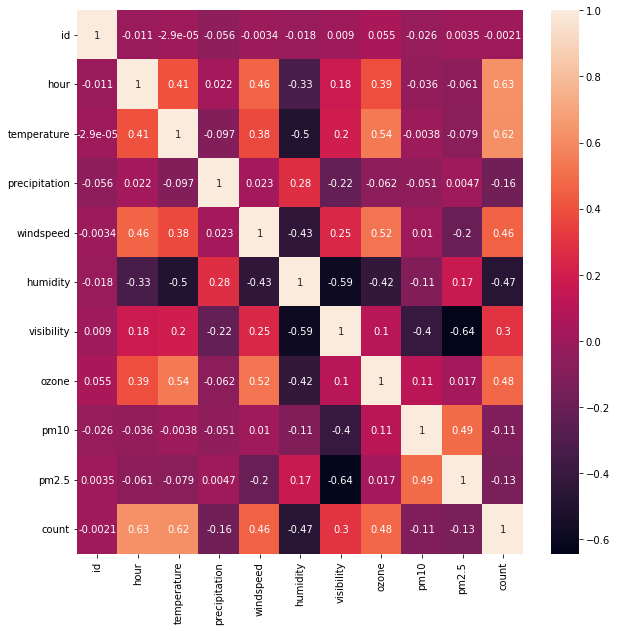

In [ ]:
plt.figure(figsize = (10, 10))
sns.heatmap(train.corr(), annot = True)

개수와 시간, 온도, 풍속, 오존은 관계가 있음

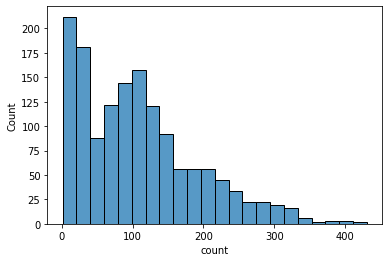

In [ ]:
sns.histplot(data=train,x='count')

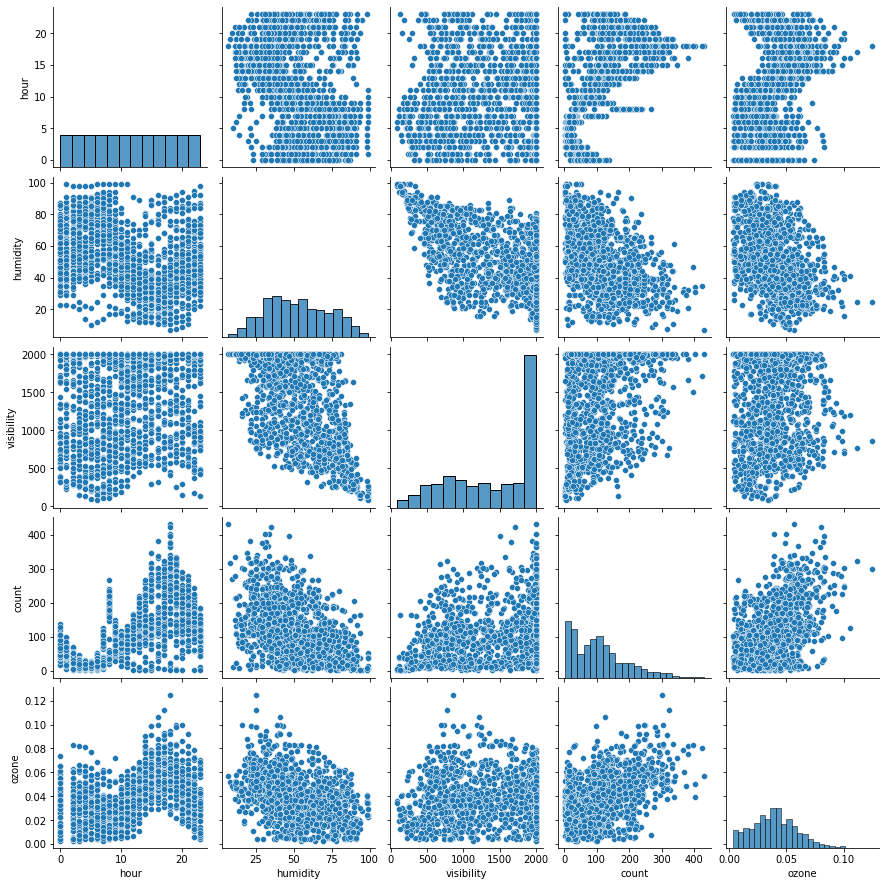

## 데이터 전처리

In [ ]:
train.isna().sum()

id                 0
hour               0
temperature        2
precipitation      2
windspeed          9
humidity           2
visibility         2
ozone             76
pm10              90
pm2.5            117
count              0
dtype: int64

In [ ]:
def fill_na(df, column) :
    df[column] = df[column].fillna(df[column].mean())

In [ ]:
fill_na(train,['temperature','precipitation','windspeed','humidity','visibility','ozone','pm10','pm2.5'])

In [ ]:
test.isna().sum()

id                0
hour              0
temperature       1
precipitation     1
windspeed         1
humidity          1
visibility        1
ozone            35
pm10             37
pm2.5            36
dtype: int64

In [ ]:
fill_na(test,['temperature','precipitation','windspeed','humidity','visibility','ozone','pm10','pm2.5'])

### 불쾌지수 칼럼 만들기

 불쾌지수=1.8x기온–0.55x(1–습도)x(1.8x기온–26)+32

In [ ]:
train=train.drop('discomfort_index',axis=1)

In [ ]:
test=test.drop('discomfort_index',axis=1)

In [ ]:
def disgusting(df):
  df['discomfort_index']=df['temperature']*1.8-0.55*(1-df['humidity']/100)*(1.8*df['temperature']-26)+32

In [ ]:
disgusting(train)

In [ ]:
train.head()

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count,discomfort_index
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0,61.13793
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0,65.26852
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0,57.13319
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0,49.46926
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0,71.23835


In [ ]:
disgusting(test)

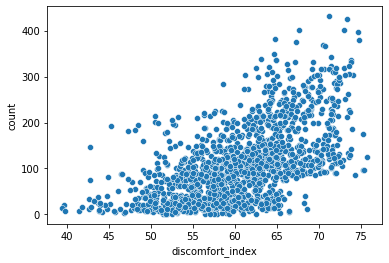

In [ ]:
sns.scatterplot(data=train,x='discomfort_index',y='count')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1459 non-null   int64  
 1   hour              1459 non-null   int64  
 2   temperature       1459 non-null   float64
 3   precipitation     1459 non-null   float64
 4   windspeed         1459 non-null   float64
 5   humidity          1459 non-null   float64
 6   visibility        1459 non-null   float64
 7   ozone             1459 non-null   float64
 8   pm10              1459 non-null   float64
 9   pm2.5             1459 non-null   float64
 10  count             1459 non-null   float64
 11  discomfort_index  1459 non-null   float64
dtypes: float64(10), int64(2)
memory usage: 136.9 KB


## 불쾌지수 등급별로 나누기

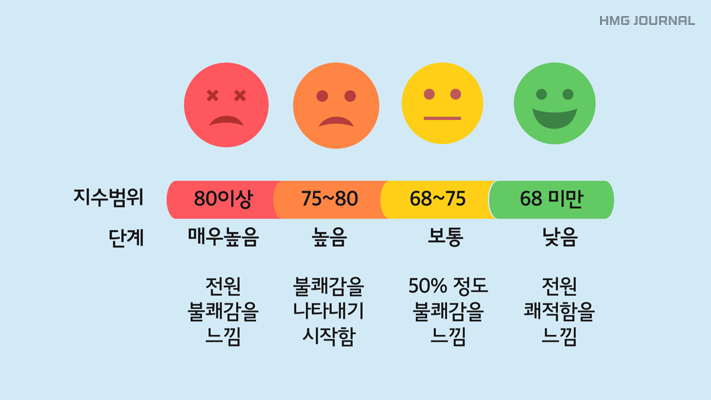

In [ ]:
def level_discomfort(df):
  if df['discomfort_index']>=80:
    df['discomfort_level']=4
  elif 75<=df['discomfort_index']<80:
    df['discomfort_level']=3
  elif 68<=df['discomfort_index']<75:
    df['discomfort_level']=2
  elif df['discomfort_index']<68:
    df['discomfort_level']=1


In [ ]:
train.loc[train['discomfort_index']>=80,'discomfort_level']=4
train.loc[(train['discomfort_index']<80)&(train['discomfort_index']>=75),'discomfort_level']=3
train.loc[(train['discomfort_index']<75)&(train['discomfort_index']>=68),'discomfort_level']=2
train.loc[train['discomfort_index']<68,'discomfort_level']=1

In [ ]:
test.loc[test['discomfort_index']>=80,'discomfort_level']=4
test.loc[(test['discomfort_index']<80)&(test['discomfort_index']>=75),'discomfort_level']=3
test.loc[(test['discomfort_index']<75)&(test['discomfort_index']>=68),'discomfort_level']=2
test.loc[test['discomfort_index']<68,'discomfort_level']=1

In [ ]:
train.head()

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count,discomfort_index,discomfort_level
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0,61.13793,1.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0,65.26852,1.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0,57.13319,1.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0,49.46926,1.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0,71.23835,2.0


In [ ]:
train['discomfort_level'].value_counts()

1.0    1250
2.0     205
3.0       4
Name: discomfort_level, dtype: int64

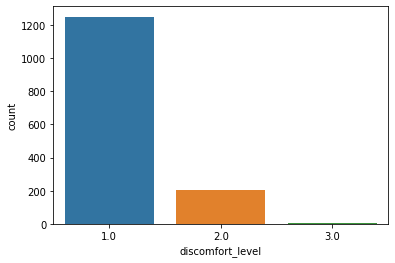

In [ ]:
sns.countplot(data=train,x='discomfort_level')

## 모델링

로지스틱회귀, XGBoost,랜덤포레스트

In [ ]:
X_train = train.drop(['id', 'count'], axis = 1)
y_train = train['count']
X_test = test.drop('id', axis = 1)

In [ ]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

로지스틱 회귀

In [ ]:
lr_clf=LogisticRegression()

params={
    'penalty':['l1','l2'],
    'C':[0.01,0.1,1,5,10]
}
grid_clf=GridSearchCV(lr_clf,param_grid=params,scoring='accuracy',cv=3)
grid_clf.fit(X_train,y_train)
print('Logiscit regression best C parameter:',grid_clf.best_params_)

Logiscit regression best C parameter: {'C': 0.01, 'penalty': 'l2'}


In [ ]:
submission['count'] = grid_clf.predict(X_test)

In [ ]:
submission.to_csv('LogisticRegression.csv', index = False)

랜덤포레스트

In [ ]:
rf_clf=RandomForestRegressor()

params = {'min_samples_split': [30, 50, 70],
        'max_depth': [5, 6, 7],
        'n_estimators': [50, 150, 250]}

grid_rf=GridSearchCV(rf_clf,param_grid=params,scoring='neg_mean_squared_error',cv=3)
grid_rf.fit(X_train,y_train)
print('RandomForest Regression best :',grid_rf.best_params_)

RandomForest Regression best : {'max_depth': 7, 'min_samples_split': 30, 'n_estimators': 250}


In [ ]:
submission=pd.read_csv('submission.csv')


In [ ]:
submission['count']=grid_rf.predict(X_test)

In [ ]:
submission.to_csv('RandomForestRegressor.csv', index = False)

In [ ]:
train.head()

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count,discomfort_index
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0,222.996
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0,331.333
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0,14.978
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0,-286.313
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0,174.530


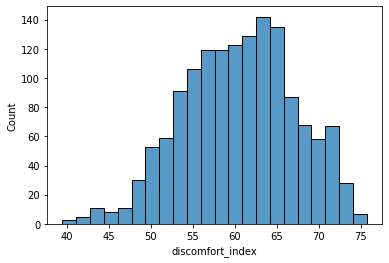

In [ ]:
sns.histplot(data=train,x='discomfort_index')

뭐지..? 불쾌지수에 -값이 나올 수가 있는건가